### Dependencies 

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime 
import random

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

# Reflect Tables into SQLAlchemy ORM

In [2]:
# create engine to hawaii.sqlite
database_path = 'Resources/hawaii.sqlite'
engine = create_engine(f"sqlite:///{database_path}")

In [3]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [7]:
# Find the most recent date in the data set.
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x254b86ba4a8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1}

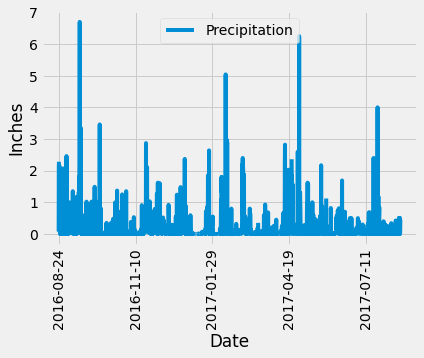

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date = datetime.strptime(recent_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_year = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date >= year_ago).\
order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_year, columns=['Precipitation', 'Date'])
prcp_df.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot.line()
plt.xticks(rotation='vertical')
plt.ylabel('Inches')
plt.savefig('plots/Precipitation.png', bbox_inches='tight')

In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [10]:
station_query = session.query(Station).first()
station_query.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x254b9ad7da0>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0}

In [11]:
# Retrieve all information from Station
for row in session.query(Station.station, Station.name, Station.id).all():
    print(row)

('USC00519397', 'WAIKIKI 717.2, HI US', 1)
('USC00513117', 'KANEOHE 838.1, HI US', 2)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 3)
('USC00517948', 'PEARL CITY, HI US', 4)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 5)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 6)
('USC00519281', 'WAIHEE 837.5, HI US', 7)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 8)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 9)


In [12]:
# Design a query to calculate the total number stations in the dataset
print('Total Number of stations is: ' + str(session.query(Station.station).count()))

Total Number of stations is: 9


In [13]:
# Design a query to find the most active stations and list them in descending order
session.query(Measurement.id, Measurement.station, func.count(Measurement.station)).order_by(desc(func.count(Measurement.station))).group_by(Measurement.station).all()

[(12188, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2725, 'USC00513117', 2709),
 (9519, 'USC00519523', 2669),
 (16939, 'USC00516128', 2612),
 (5434, 'USC00514830', 2202),
 (14960, 'USC00511918', 1979),
 (7636, 'USC00517948', 1372),
 (9008, 'USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = session.query(Measurement.station).order_by(desc(func.count(Measurement.station))).group_by(Measurement.station).first()

min_temp = session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station == active_station[0]).all()
max_temp = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station == active_station[0]).all()
avg_temp = session.query(Measurement.station, func.round(func.avg(Measurement.tobs),2)).filter(Measurement.station == active_station[0]).all()
count_temp = session.query(Measurement.station, func.count(Measurement.tobs)).filter(Measurement.station == active_station[0]).all()
print(f"Station ID '{min_temp[0][0]}' Minimum observed temperature is {min_temp[0][1]}")
print(f"Station ID '{max_temp[0][0]}' Maximum observed temperature is {max_temp[0][1]}")
print(f"Station ID '{avg_temp[0][0]}' Averaged observed temperature is {avg_temp[0][1]}")
print(f"Station ID '{count_temp[0][0]}' had a total of {count_temp[0][1]} observed temperatures")

Station ID 'USC00519281' Minimum observed temperature is 54.0
Station ID 'USC00519281' Maximum observed temperature is 85.0
Station ID 'USC00519281' Averaged observed temperature is 71.66
Station ID 'USC00519281' had a total of 2772 observed temperatures


In [15]:
# Query the last 12 months of temperature observation data for the most active station id
tobs_year = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date >= year_ago).\
filter(Measurement.station == active_station[0]).order_by(Measurement.tobs.asc()).all()

tobs_year

[('USC00519281', 59.0),
 ('USC00519281', 59.0),
 ('USC00519281', 59.0),
 ('USC00519281', 60.0),
 ('USC00519281', 60.0),
 ('USC00519281', 61.0),
 ('USC00519281', 62.0),
 ('USC00519281', 62.0),
 ('USC00519281', 62.0),
 ('USC00519281', 62.0),
 ('USC00519281', 62.0),
 ('USC00519281', 62.0),
 ('USC00519281', 63.0),
 ('USC00519281', 63.0),
 ('USC00519281', 63.0),
 ('USC00519281', 63.0),
 ('USC00519281', 64.0),
 ('USC00519281', 64.0),
 ('USC00519281', 64.0),
 ('USC00519281', 65.0),
 ('USC00519281', 65.0),
 ('USC00519281', 65.0),
 ('USC00519281', 65.0),
 ('USC00519281', 65.0),
 ('USC00519281', 65.0),
 ('USC00519281', 65.0),
 ('USC00519281', 66.0),
 ('USC00519281', 66.0),
 ('USC00519281', 66.0),
 ('USC00519281', 66.0),
 ('USC00519281', 66.0),
 ('USC00519281', 67.0),
 ('USC00519281', 67.0),
 ('USC00519281', 67.0),
 ('USC00519281', 67.0),
 ('USC00519281', 67.0),
 ('USC00519281', 67.0),
 ('USC00519281', 67.0),
 ('USC00519281', 67.0),
 ('USC00519281', 67.0),
 ('USC00519281', 67.0),
 ('USC00519281',

In [16]:
# Create a dataframe with tobs data
tobs_df = pd.DataFrame(tobs_year, columns=['Station', 'Temperature'])
tobs_df.head()

,Station,Temperature
0,USC00519281,59.0
1,USC00519281,59.0
2,USC00519281,59.0
3,USC00519281,60.0
4,USC00519281,60.0


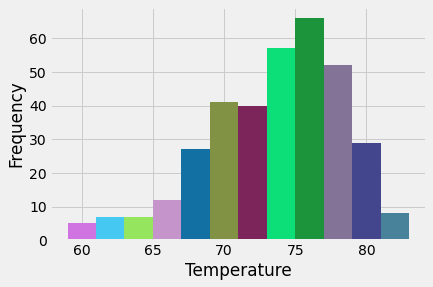

In [17]:
# Plot tobs results as a histogram
n, m, patches = plt.hist(tobs_df.Temperature, bins=12, rwidth=1)

# Random color selection
for i in range(len(n)):
    color = f"#{random.randrange(0x1000000):06x}"
    patches[i].set_fc(color)
    
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.savefig('plots/station_tobs.png', bbox_inches='tight')

# Close session

In [18]:
# Close Session
session.close()